Based by "https://github.com/google/eng-edu/tree/master/ml/guides/text_classification".

## 1. Load the Dataset

In [1]:
import os
import random

import numpy as np
import pandas as pd


def load_imdb_sentiment_analysis_dataset(data_path, seed=321):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [2]:
((train_texts, train_labels), (test_texts, test_labels)) = load_imdb_sentiment_analysis_dataset("")

In [3]:
len(train_texts)

25000

## 2. Explore Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [5]:
print("Number of the training sample:",get_num_words_per_sample(train_texts))
print("Number of the test sample:",get_num_words_per_sample(test_texts))

Number of the training sample: 174.0
Number of the test sample: 172.0


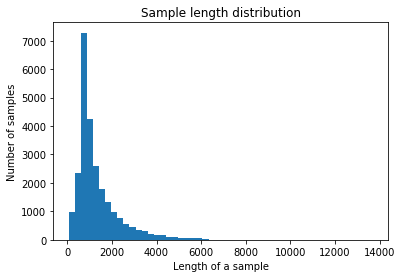

In [6]:
plot_sample_length_distribution(train_texts)

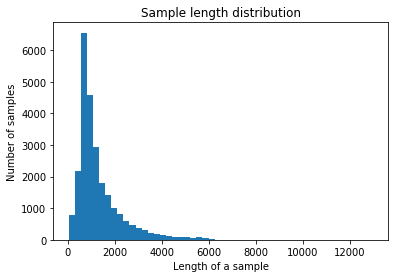

In [7]:
plot_sample_length_distribution(test_texts)

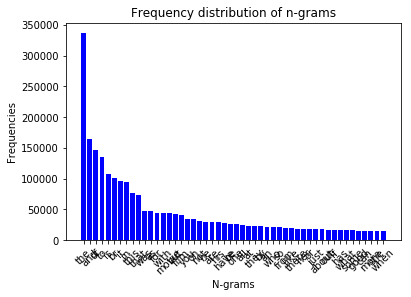

In [8]:
plot_frequency_distribution_of_ngrams(train_texts)

## 3. Vectorize data

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as ngram vectors.
    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    return x_train, x_val


def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.
    1 text = 1 sequence vector with fixed length.
    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [10]:
print(len(train_texts)/get_num_words_per_sample(train_texts))

143.67816091954023


In [11]:
x_train, x_val = ngram_vectorize(train_texts, train_labels, test_texts)

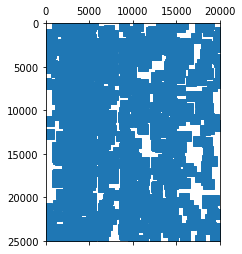

In [12]:
plt.spy(x_train, precision=0.3)
plt.show()

## 4. Build Model

In [4]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D


def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.
    # Arguments
        num_classes: int, number of classes.
    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation




def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.
    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.
    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.
    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model




## 5. Train data

### Train ngram model

In [5]:
import argparse
import time

import tensorflow as tf
import numpy as np

FLAGS = None


def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('imdb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='',
                        help='input data directory')
    FLAGS, unparsed = parser.parse_known_args()

    # Using the IMDb movie reviews dataset to demonstrate training n-gram model
    data = load_imdb_sentiment_analysis_dataset(FLAGS.data_dir)
    train_ngram_model(data)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
 - 21s - loss: 0.4715 - acc: 0.8538 - val_loss: 0.3228 - val_acc: 0.8874
Epoch 2/1000
 - 19s - loss: 0.2330 - acc: 0.9192 - val_loss: 0.2515 - val_acc: 0.9021
Epoch 3/1000
 - 19s - loss: 0.1688 - acc: 0.9412 - val_loss: 0.2325 - val_acc: 0.9063
Epoch 4/1000
 - 20s - loss: 0.1357 - acc: 0.9537 - val_loss: 0.2310 - val_acc: 0.9052
Epoch 5/1000
 - 19s - loss: 0.1108 - acc: 0.9638 - val_loss: 0.2326 - val_acc: 0.9047
Epoch 6/1000
 - 20s - loss: 0.0929 - acc: 0.9698 - val_loss: 0.2395 - val_acc: 0.9018
Validation accuracy: 0.90176, loss: 0.23947998819351196


### Train sequence model

In [ ]:
import argparse
import time

import tensorflow as tf
import numpy as np


FLAGS = None

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000


def train_sequence_model(data,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('rotten_tomatoes_sepcnn_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='',
                        help='input data directory')
    FLAGS, unparsed = parser.parse_known_args()

    # Using the Rotten tomatoes movie reviews dataset to demonstrate
    # training sequence model.
    data = load_rotten_tomatoes_sentiment_analysis_dataset(
            FLAGS.data_dir)
    train_sequence_model(data)

### Train fine tuned sequence model

In [ ]:
import os
import argparse
import time

import tensorflow as tf
import numpy as np


FLAGS = None

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000


def _get_embedding_matrix(word_index, embedding_data_dir, embedding_dim):
    """Gets embedding matrix from the embedding index data.
    # Arguments
        word_index: dict, word to index map that was generated from the data.
        embedding_data_dir: string, path to the pre-training embeddings.
        embedding_dim: int, dimension of the embedding vectors.
    # Returns
        dict, word vectors for words in word_index from pre-trained embedding.
    # References:
        https://nlp.stanford.edu/projects/glove/
        Download and uncompress archive from:
        http://nlp.stanford.edu/data/glove.6B.zip
    """

    # Read the pre-trained embedding file and get word to word vector mappings.
    embedding_matrix_all = {}

    # We are using 200d GloVe embeddings.
    fname = os.path.join(embedding_data_dir, 'glove.6B.200d.txt')
    with open(fname) as f:
        for line in f:  # Every line contains word followed by the vector value
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix_all[word] = coefs

    # Prepare embedding matrix with just the words in our word_index dictionary
    num_words = min(len(word_index) + 1, TOP_K)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= TOP_K:
            continue
        embedding_vector = embedding_matrix_all.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def train_fine_tuned_sequence_model(data,
                                    embedding_data_dir,
                                    learning_rate=1e-3,
                                    epochs=1000,
                                    batch_size=128,
                                    blocks=2,
                                    filters=64,
                                    dropout_rate=0.2,
                                    embedding_dim=200,
                                    kernel_size=3,
                                    pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        embedding_data_dir: string, path to the pre-training embeddings.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    embedding_matrix = _get_embedding_matrix(
        word_index, embedding_data_dir, embedding_dim)

    # Create model instance. First time we will train rest of network while
    # keeping embedding layer weights frozen. So, we set
    # is_embedding_trainable as False.
    model = build_model.sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                                     use_pretrained_embedding=True,
                                     is_embedding_trainable=False,
                                     embedding_matrix=embedding_matrix)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    model.fit(x_train,
              train_labels,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=(x_val, val_labels),
              verbose=2,  # Logs once per epoch.
              batch_size=batch_size)

    # Save the model.
    model.save_weights('sequence_model_with_pre_trained_embedding.h5')

    # Create another model instance. This time we will unfreeze the embedding
    # layer and let it fine-tune to the given dataset.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                                     use_pretrained_embedding=True,
                                     is_embedding_trainable=True,
                                     embedding_matrix=embedding_matrix)

    # Compile model with learning parameters.
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Load the weights that we had saved into this new model.
    model.load_weights('sequence_model_with_pre_trained_embedding.h5')

    # Train and validate model.
    history = model.fit(x_train,
                        train_labels,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(x_val, val_labels),
                        verbose=2,  # Logs once per epoch.
                        batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('tweet_weather_sepcnn_fine_tuned_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='./data',
                        help='input data directory')
    parser.add_argument('--embedding_data_dir', type=str, default='./data',
                        help='embedding input data directory')
    FLAGS, unparsed = parser.parse_known_args()

    # Using the tweet weather topic classification dataset to demonstrate
    # training sequence model with fine-tuned pre-trained embedding.
    data = load_tweet_weather_topic_classification_dataset(
            FLAGS.data_dir)
    train_fine_tuned_sequence_model(data, FLAGS.embedding_data_dir)

### Batch train sequence model

In [ ]:
import argparse
import time

import tensorflow as tf
import numpy as np



FLAGS = None

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000


def _data_generator(x, y, num_features, batch_size):
    """Generates batches of vectorized texts for training/validation.
    # Arguments
        x: np.matrix, feature matrix.
        y: np.ndarray, labels.
        num_features: int, number of features.
        batch_size: int, number of samples per batch.
    # Returns
        Yields feature and label data in batches.
    """
    num_samples = x.shape[0]
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            yield x_batch, y_batch


def batch_train_sequence_model(data,
                               learning_rate=1e-3,
                               epochs=1000,
                               batch_size=128,
                               blocks=2,
                               filters=64,
                               dropout_rate=0.2,
                               embedding_dim=200,
                               kernel_size=3,
                               pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = build_model.sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Create training and validation generators.
    training_generator = _data_generator(
        x_train, train_labels, num_features, batch_size)
    validation_generator = _data_generator(
        x_val, val_labels, num_features, batch_size)

    # Get number of training steps. This indicated the number of steps it takes
    # to cover all samples in one epoch.
    steps_per_epoch = x_train.shape[0] // batch_size
    if x_train.shape[0] % batch_size:
        steps_per_epoch += 1

    # Get number of validation steps.
    validation_steps = x_val.shape[0] // batch_size
    if x_val.shape[0] % batch_size:
        validation_steps += 1

    # Train and validate model.
    history = model.fit_generator(
            generator=training_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            epochs=epochs,
            verbose=2)  # Logs once per epoch.

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('amazon_reviews_sepcnn_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='',
                        help='input data directory')
    FLAGS, unparsed = parser.parse_known_args()

    # Using the Amazon reviews dataset to demonstrate training of
    # sequence model with batches of data.
    data = load_amazon_reviews_sentiment_analysis_dataset(
            FLAGS.data_dir)
    batch_train_sequence_model(data)

## 6. Tune model

Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
 - 13s - loss: 0.6688 - acc: 0.8324 - val_loss: 0.6483 - val_acc: 0.8429
Epoch 2/1000
 - 12s - loss: 0.6224 - acc: 0.8758 - val_loss: 0.6100 - val_acc: 0.8517
Epoch 3/1000
 - 13s - loss: 0.5826 - acc: 0.8791 - val_loss: 0.5771 - val_acc: 0.8560
Epoch 4/1000
 - 12s - loss: 0.5484 - acc: 0.8835 - val_loss: 0.5488 - val_acc: 0.8593
Epoch 5/1000
 - 14s - loss: 0.5187 - acc: 0.8858 - val_loss: 0.5242 - val_acc: 0.8614
Epoch 6/1000
 - 13s - loss: 0.4923 - acc: 0.8873 - val_loss: 0.5026 - val_acc: 0.8639
Epoch 7/1000
 - 13s - loss: 0.4699 - acc: 0.8901 - val_loss: 0.4836 - val_acc: 0.8658
Epoch 8/1000
 - 13s - loss: 0.4500 - acc: 0.8917 - val_loss: 0.4668 - val_acc: 0.8674
Epoch 9/1000
 - 15s - loss: 0.4318 - acc: 0.8964 - val_loss: 0.4517 - val_acc: 0.8697
Epoch 10/1000
 - 15s - loss: 0.4154 - acc: 0.8989 - val_loss: 0.4381 - val_acc: 0.8712
Epoch 11/1000
 - 14s - loss: 0.4015 - acc: 0.8992 - val_loss: 0.4259 - val_acc: 0.8728
Ep

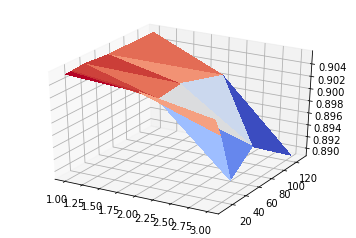

In [6]:
import argparse
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm



FLAGS = None


def tune_ngram_model(data):
    """Tunes n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
    """
    # Select parameter values to try.
    num_layers = [1, 2, 3]
    num_units = [8, 16, 32, 64, 128]

    # Save parameter combination and results.
    params = {
        'layers': [],
        'units': [],
        'accuracy': [],
    }

    # Iterate over all parameter combinations.
    for layers in num_layers:
        for units in num_units:
                params['layers'].append(layers)
                params['units'].append(units)

                accuracy, _ = train_ngram_model(
                    data=data,
                    layers=layers,
                    units=units)
                print(('Accuracy: {accuracy}, Parameters: (layers={layers}, '
                       'units={units})').format(accuracy=accuracy,
                                                layers=layers,
                                                units=units))
                params['accuracy'].append(accuracy)
    _plot_parameters(params)


def _plot_parameters(params):
    """Creates a 3D surface plot of given parameters.
    # Arguments
        params: dict, contains layers, units and accuracy value combinations.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(params['layers'],
                    params['units'],
                    params['accuracy'],
                    cmap=cm.coolwarm,
                    antialiased=False)
    plt.show()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='',
                        help='input data directory')
    FLAGS, unparsed = parser.parse_known_args()

    # Using the IMDb movie reviews dataset to demonstrate training n-gram model
    data = load_imdb_sentiment_analysis_dataset(FLAGS.data_dir)
    tune_ngram_model(data)